<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>4<sup>th</sup> April 2019</i>

This notebook plan doesn't reflect the chronologic order of our reflection. To solve this problem, we start with a very simple model (linear regression) with almost raw data (we removed the columns with missing values and with string object). Incrementally, we improved the data and the model by trying new analysis, processing and parameters. However to simplify the lecture of the notebook we chose to present first the data exploration and pre-processing and then the comparation of the models we think were the most interesting.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

<div class="">
    <h3>1. Data Exploration and Pre-Processing</h3>
</div>

- Introduction (import and basic analysis)
- Visualizing our target SalePrice
- Missing value dropping : cleaned_housePricingDF
- Missing value filling
- Missing value filling, with mean
- Handeling string columns
- Visualization of the rest of the data frame
- Study of correlation & removing redundancy
- Removing outliers

<div class="">
    <h3>2. Model Selection</h3>
</div>

- Linear Regression
- Gaussian Process Regressor
- Lasso
- Gradient Boosting
- Selection and submission

# 1. Data Exploration and Pre-Processing
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

<h3> Introduction </h3>
    

In [1]:
%matplotlib inline
import os
import sys
import re
import random
import matplotlib
#import implicit

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer

#from tqdm import tqdm
from time import time

# Read the .csv file
housePricingDF = pd.read_csv('challenge_data/train.csv')
test = pd.read_csv('challenge_data/test.csv')


In [2]:
housePricingDF.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,600.500000,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,346.554469,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,300.750000,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,600.500000,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,900.250000,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1200.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
housePricingDF.shape

(1200, 81)

In [4]:
housePricingDF.get_dtype_counts()

float64     3
int64      35
object     43
dtype: int64

In [5]:
housePricingDF.nunique()[:10]

Id             1200
MSSubClass       15
MSZoning          5
LotFrontage     106
LotArea         913
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
dtype: int64

In [6]:
housePricingDF['Street'].unique()

array(['Pave', 'Grvl'], dtype=object)

This gives us the basic knowledge we need: 
This a regression problem (super)
the dataset contains 1200 samples, which is not big. So the computations shouldn't be too long, it doesn't seem really necessary to reduce the dataset and we will be able to try and perhaps combine a lot of differents models. 
Some values are missing: only 990 count for LotFrontage for example. What can also be noticed is that there are only 38 numerical columns over a total of 81 columns, which can be an issue for some models. Somes columns have not a lot of different values, like 'Street' which have 2 differents values 'Pave' (paved) and 'Grvl' (gravel). We can suspected that they won't have a big impact on the prediction.

But let's start with the basic. What does our target columns looks like ?

<h3> SalePrice analysis <h3/>

In [9]:
housePricingDF['SalePrice'].describe()

count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

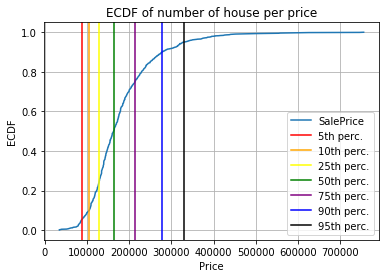

0.02     79000.00
0.05     87975.00
0.10    105990.00
0.25    129900.00
0.50    163700.00
0.75    214000.00
0.90    278150.00
0.95    329205.00
0.98    402017.22
Name: SalePrice, dtype: float64

In [10]:
uniqueHouse = housePricingDF['Id'].nunique()

housePrice = housePricingDF['SalePrice'].value_counts().sort_index().cumsum().div(uniqueHouse)

fig, ax = plt.subplots()
housePrice.plot(x=0,y=1, ax=ax)
plt.grid()
# Calculate and plot the 5 important percentiles
colors = ['red','orange','yellow','green','purple','blue','black']
for i, quantile in enumerate([0.05,.1, 0.25, .5, .75, .9,0.95]):
   ax.axvline(housePricingDF['SalePrice'].quantile(quantile),label='%.0fth perc.' % (quantile*100),color=colors[i])



ax.set_title('ECDF of number of house per price')
ax.set_xlabel('Price')
ax.set_ylabel('ECDF')
ax.legend()
plt.show()
housePricingDF['SalePrice'].quantile([0.02,0.05,.1, 0.25, .5, .75, .9,0.95,0.98])

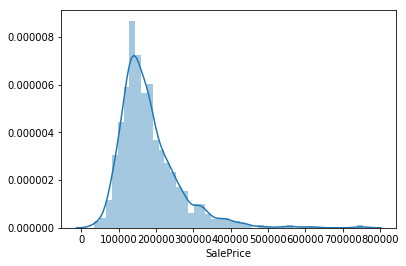

In [11]:
sns.distplot(housePricingDF['SalePrice'])

<p> First of all, we can see that the price of the houses are mainly between 100 000 and 300 000 dollars. However, the price is widely reparted and goes from 35 000 to 755 000 dollars. 
    We can also observe that the price are distributed like a gaussian. So this might be developped as a potentiel model in the next part. </p>
    
  <p>  Now let's have a look in depth to our data. The first thing that we'll have to do is to focus on the missing values of the data. Indeed, they might distort our different model. Another thing to do is also to study attributes of the data to select those which will be relevant to predict the sale price </p>
    

To deal with missing values, we got inspiration from: https://www.kaggle.com/srinivasmj/gradient-boosting-regression-droping-correlation.

<h3> Drop missing values </h3>

Let's treat the missing values : should we delete the columns where some information is missing or should we fill them ?

In [12]:
#Let's see how much missing values there are
total = housePricingDF.isnull().sum().sort_values(ascending=False)
percent = (housePricingDF.isnull().sum() / housePricingDF.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1196,0.996667
MiscFeature,1153,0.960833
Alley,1125,0.937500
Fence,973,0.810833
FireplaceQu,564,0.470000
LotFrontage,210,0.175000
GarageType,67,0.055833
GarageCond,67,0.055833
GarageYrBlt,67,0.055833
GarageFinish,67,0.055833


There are some columns with a lot of missing values: Up to 99% for Pool Quality, which is understandable since probably most of the houses don't have pools. This can lead to mistakes in the analysis and vizualiation that we are going to do and to errors when training models. We should try to fill them, since some information can be usefull. For example if there is a pool or not can be a valuable information.
But let's start by simply drop the partly empty columns. 

In [13]:
#Let's drop them
to_drop = list(total.where(total > 0).dropna().index)
cleaned_housePricingDF = housePricingDF.drop(to_drop, 1)

ok so now we have a dataFrame cleaned_housePricingDF without missing values. But unfortunetly we had to drop 18 columns, which is almost one quarter of our database and which will probably decrease the accuracy of our model according to. 

<h3> Fill missing values </h3>


In [14]:
missing_data.head(18)

,Total,Percent
PoolQC,1196,0.996667
MiscFeature,1153,0.960833
Alley,1125,0.937500
Fence,973,0.810833
FireplaceQu,564,0.470000
LotFrontage,210,0.175000
GarageType,67,0.055833
GarageCond,67,0.055833
GarageYrBlt,67,0.055833
GarageFinish,67,0.055833


Clearly the 67 garage missing elements means that the house has no Garage. For the number of Fireplace, we can assume that the house has no FirePlace. So we can try to fill them with 'NA' for 'No Garage'.

In [15]:
def fillna_with_0(df):
    total = df.isnull().sum().sort_values(ascending=False)
    to_drop = list(total.where(total > 0).dropna().index)
    new_df = df.copy()
    new_df[to_drop] = df[to_drop].fillna(0)
    return new_df

In [16]:
def fillna_with_NA(df):
    total = df.isnull().sum().sort_values(ascending=False)
    to_drop = list(total.where(total > 0).dropna().index)
    new_df = df.copy()
    new_df[to_drop] = df[to_drop].fillna('NA')
    return new_df

In [17]:
withNA_housePricingDF = fillna_with_NA(housePricingDF)
with0_housePricingDF = fillna_with_0(housePricingDF)


Now, following our first reflection, we want to make sure to only keep relevant information.

<h3>Dealing with string columns<\h3>

But what about strings columns ? can we use them ?   
We got inspiration from the kaggle kernel:   
https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning   
https://towardsdatascience.com/data-types-from-a-machine-learning-perspective-with-examples-111ac679e8bc    

In [18]:
cols = list(withNA_housePricingDF.select_dtypes(include=['object']).columns)
print(cols)

['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


They are a lot of string columns! Let's put them into labels.

In [19]:
def label(df):
    cols = list(df.select_dtypes(include=['object']).columns)

    # Process columns and apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(df[c].values)) 
        df[c] = lbl.transform(list(df[c].values))

    # Check shape        
    print('Shape: {}'.format(df.shape))
    return df

In [20]:
#Apply it on the dataframes
cleaned_housePricingDF = label(cleaned_housePricingDF)
withNA_housePricingDF = label(withNA_housePricingDF)
with0_housePricingDF = label(with0_housePricingDF)

Shape: (1200, 63)
Shape: (1200, 81)
Shape: (1200, 81)


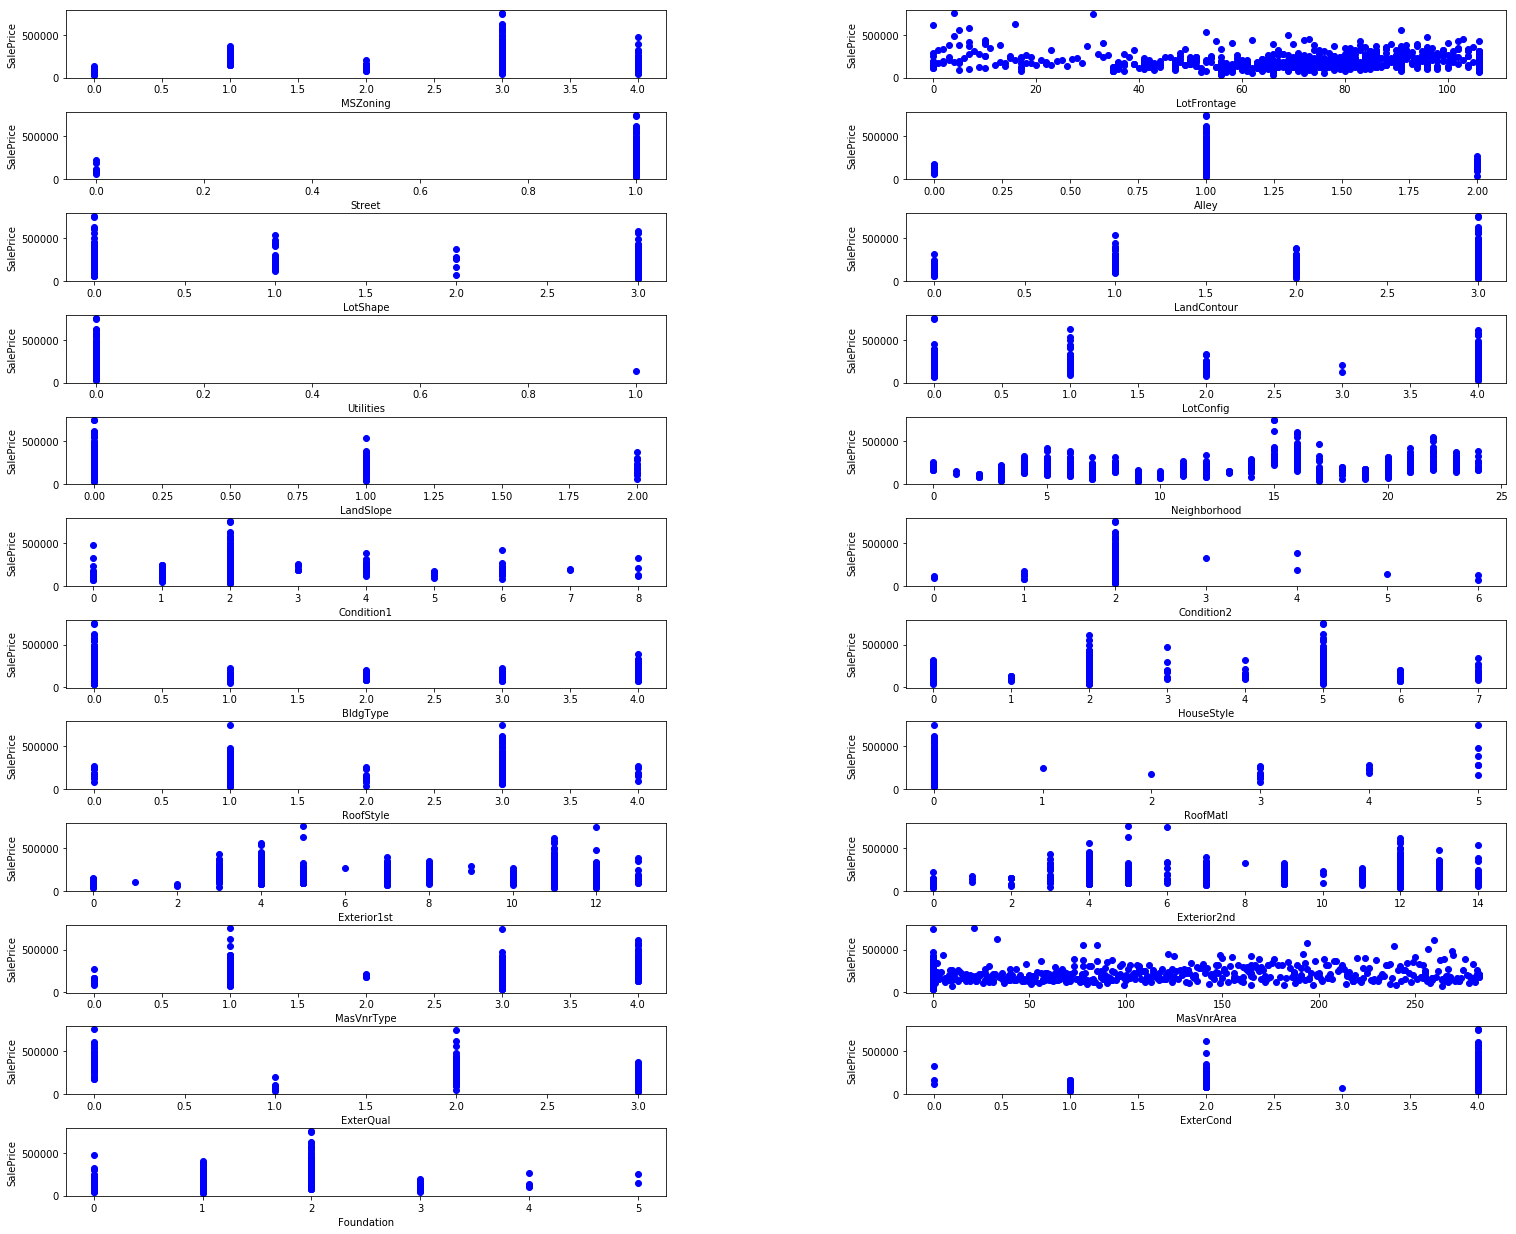

In [21]:
#Let's have a look on those new labels

plt.figure(figsize=(50,80))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,right = 0.5, top = 0.5, wspace = 0.4, hspace =0.5)
nb = len(cols)//2
for i in range(nb):
    plt.subplot(nb,2,i+1)
    plt.scatter(withNA_housePricingDF[cols[i]], withNA_housePricingDF['SalePrice'], c = "blue")
    plt.xlabel(cols[i])
    plt.ylabel("SalePrice")

plt.show()

Some have a linear relation ship but most of them haven't. Maybe if we could order the labels so it is linear. But it would probably only be benefic for the linear regressor.

<h3> Fill missing values with mean (imputation) </h3>

In [22]:
float_housePricingDF = label(housePricingDF)

imputer = Imputer(missing_values='NaN',strategy='mean',axis=0)  
imputer = imputer.fit(float_housePricingDF)
float_imputed_housePricingDF= imputer.transform(float_housePricingDF)

imputed_housePricingDF= pd.DataFrame(float_imputed_housePricingDF,columns=list(housePricingDF))

imputed_housePricingDF = label(imputed_housePricingDF)

Shape: (1200, 81)
Shape: (1200, 81)


We have now replaced the missing data by the mean. The imputed value won't be exactly right in most cases, but it might give more accurate models than dropping the column entirely. However in that case, we can see that it is may be not appropriate. If we look at the PoolQC column, the mean is 3 (we can suppose that there is few houses have pools but more than one when they have), which is innapropriate for the other standard houses


<h3>Correlation<\h3>

Our goal here is to remove redundancy. It can also be a good analysis since we will consider the linear regression model.

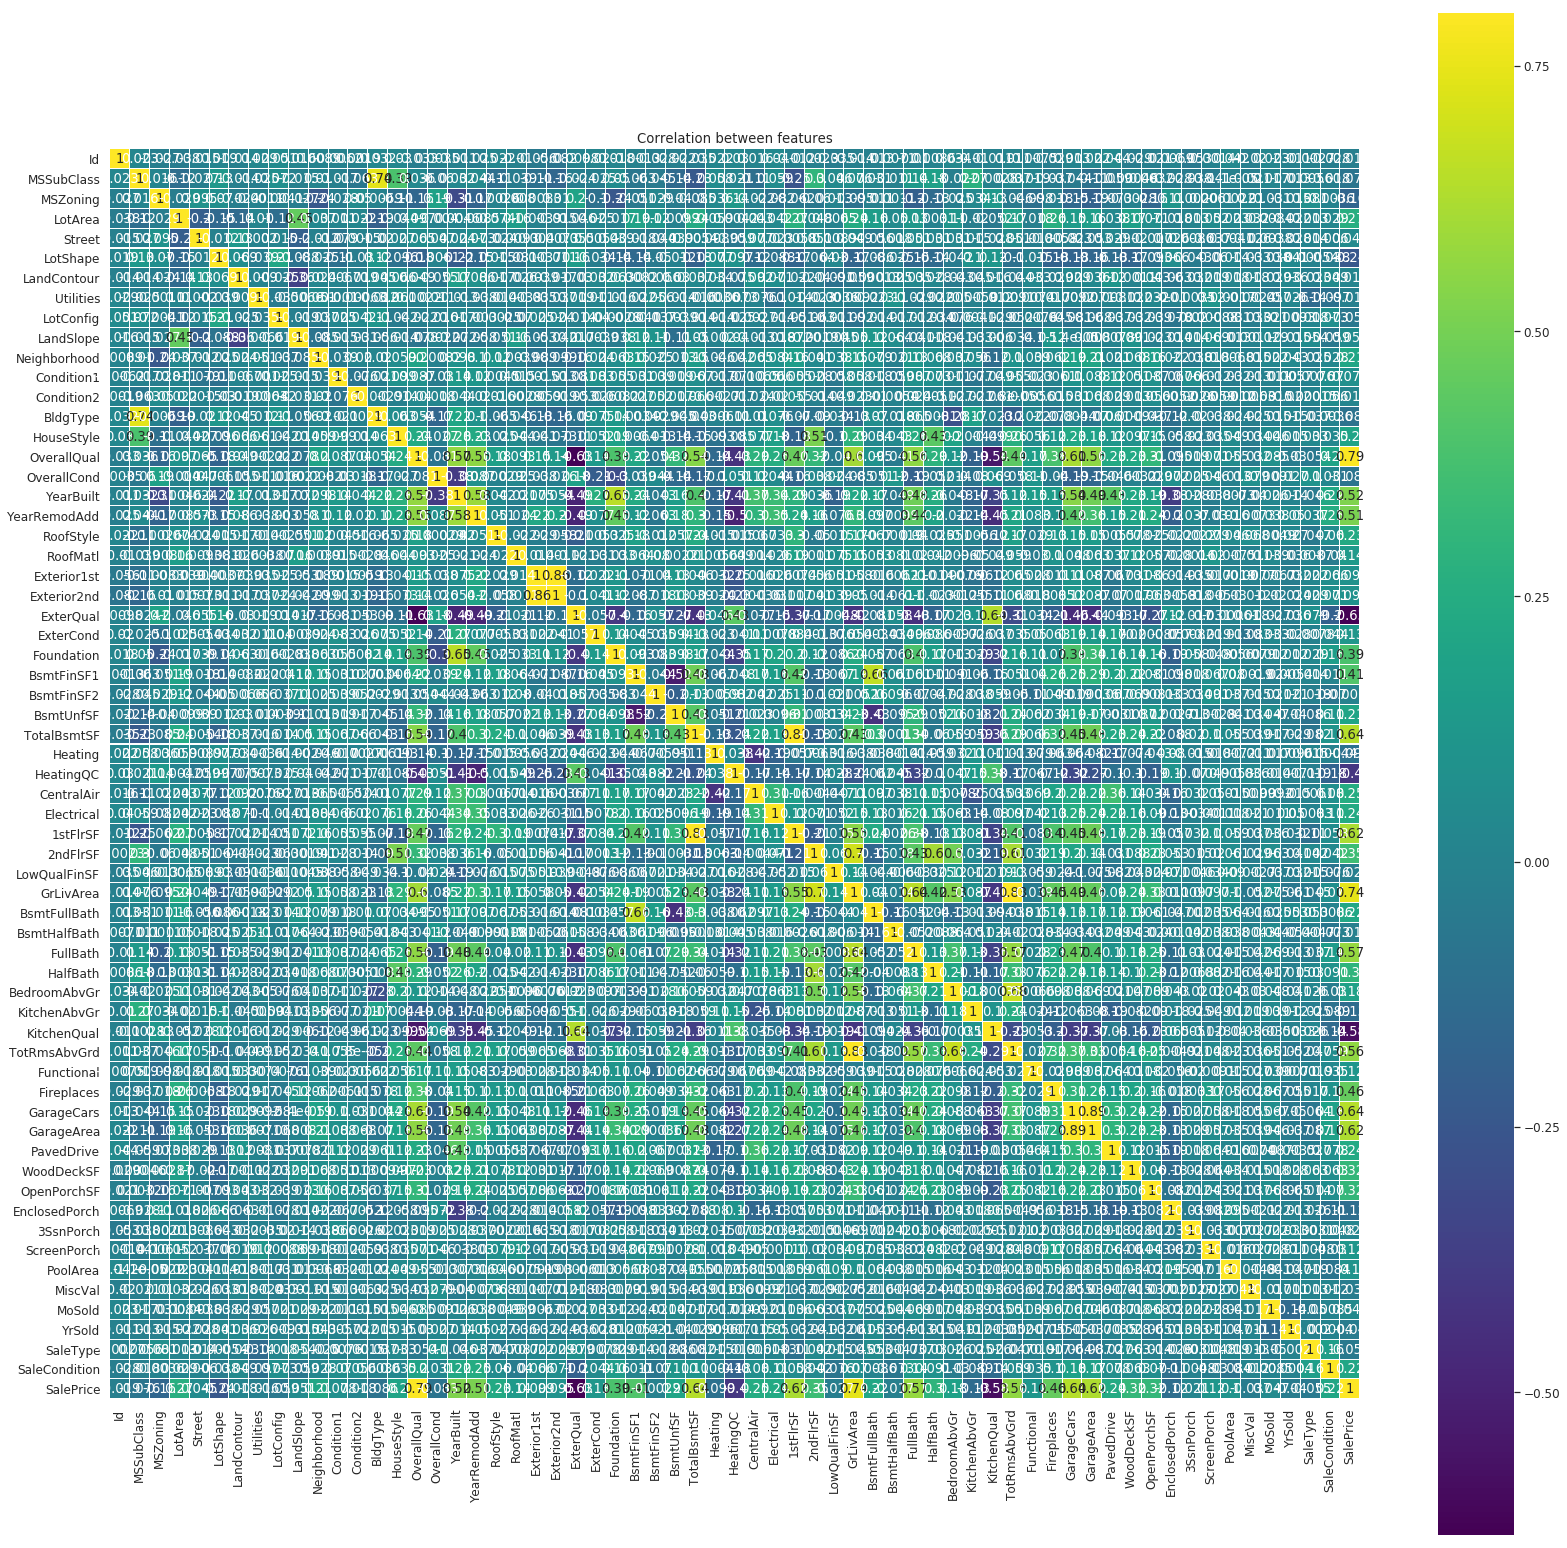

In [23]:
corrMatrix=cleaned_housePricingDF.corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(28, 28))
#sns.palplot(sns.color_palette("YlOrBr", 10))
sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features');

Interesting point here: some couples of categories (expect with SalePrice) are highly correlated. This means that training the model on them might lead to redondancy. (1stFlrSF and TotalBsmtSF, TotRmsAbvGrd and GrLivArea, GarageCars and GarageArea)
Also, it seems that SalePrice is highly correlated with several features such as OverallQual or GrLivArea which is quite surprising since one could have thought that the most important feature would have been the location. 

In [24]:
#Let's find the most correlated columns
MostCorr = []
for col in list(corrMatrix.columns):
    for kol in corrMatrix[col].drop(col)[corrMatrix[col] > 0.8].index:
        if kol != col and set((kol,col)) not in MostCorr:
            MostCorr.append(set((kol,col)))
MostCorr = [list(x) for x in MostCorr]
print('The columns with a correlation higher than 0.8: ')
MostCorr

The columns with a correlation higher than 0.8: 


[['Exterior2nd', 'Exterior1st'],
 ['1stFlrSF', 'TotalBsmtSF'],
 ['TotRmsAbvGrd', 'GrLivArea'],
 ['GarageCars', 'GarageArea']]

We found several couples of high correlated features. Let's remove each time the one which is the less correlated to SalePrice.

In [25]:
SaleCorr = corrMatrix.SalePrice.sort_values()
to_drop = []

for couple in MostCorr:
    if couple[0] not in to_drop and couple[1] not in to_drop: #So that we don't remove one entire couple
        if SaleCorr[couple[0]] < SaleCorr[couple[1]]: 
            to_drop.append(couple[0])
        else:
            to_drop.append(couple[1])
print(to_drop)

notCorr_HousePricingDF = cleaned_housePricingDF.drop(to_drop,1) #remove them from the dataFrame

['Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


Hopefully, this should save us some time. Let's visualize!     
Inspiration from:https://www.kaggle.com/srinivasmj/gradient-boosting-regression-droping-correlation

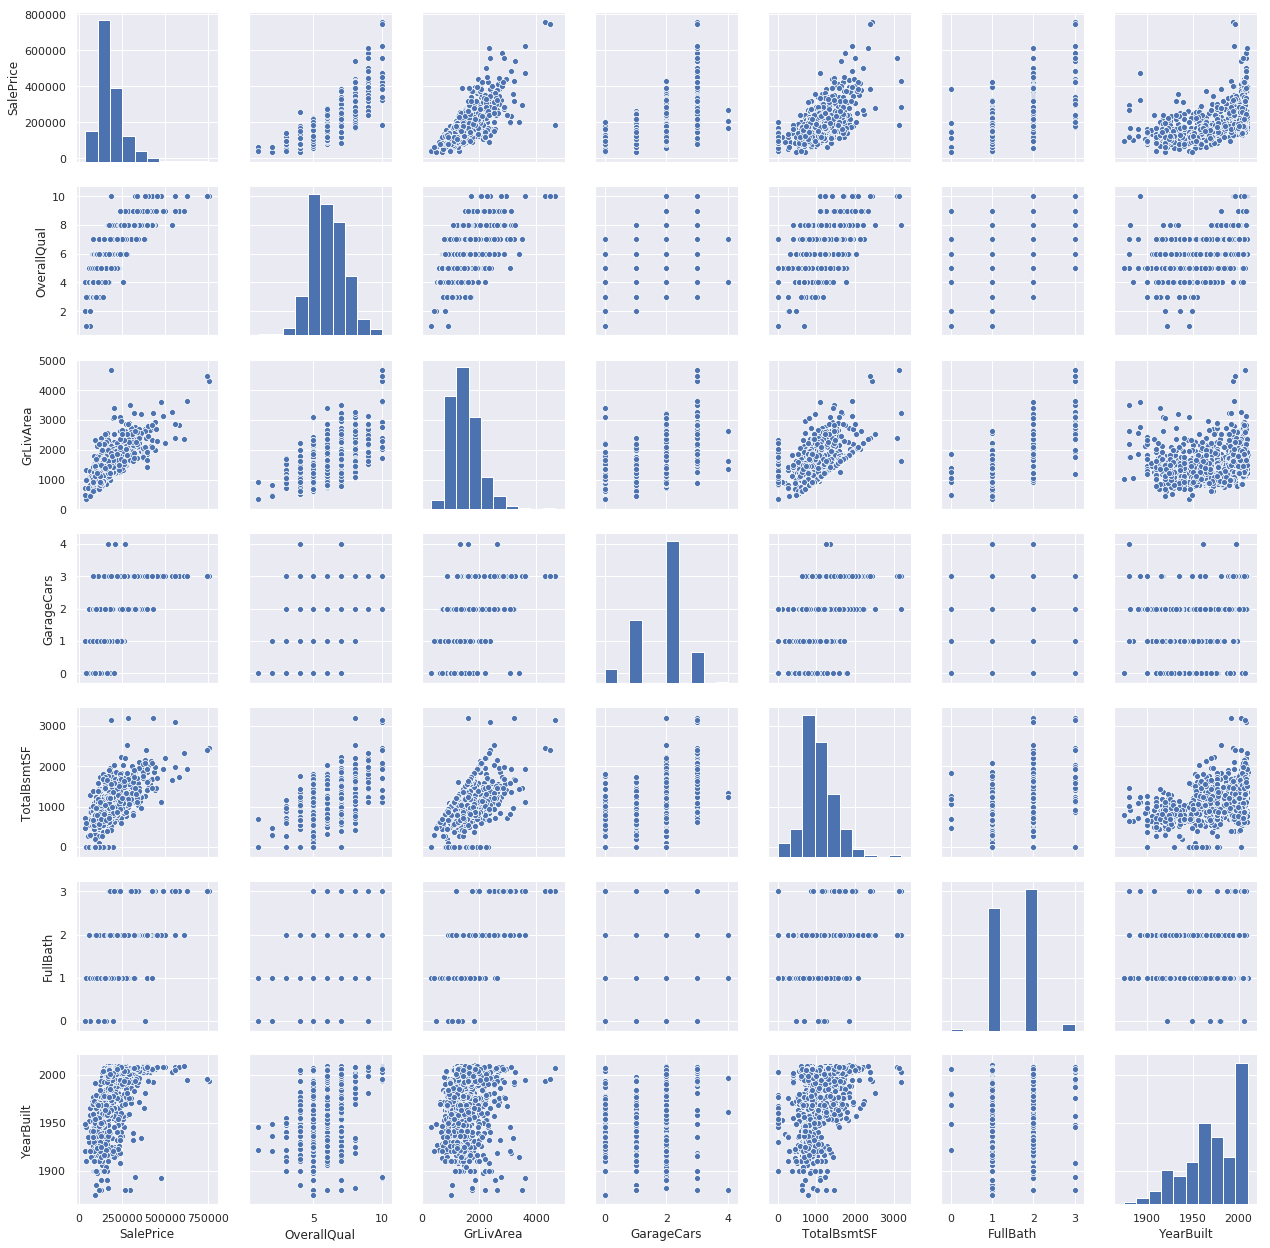

In [26]:
#scatterplot

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', \
        'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(notCorr_HousePricingDF[cols], height=2.5)
plt.show()

The relation of SalePrice with the other columns seems to be linear. Let's try a linear regression model!

<h3> Removing outlier </h3> 

In the case of linear regression, outilers can have a huge impact. So we will take the most correlated columns and see if we can clear them.

In [27]:
cols

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'FullBath',
 'YearBuilt']

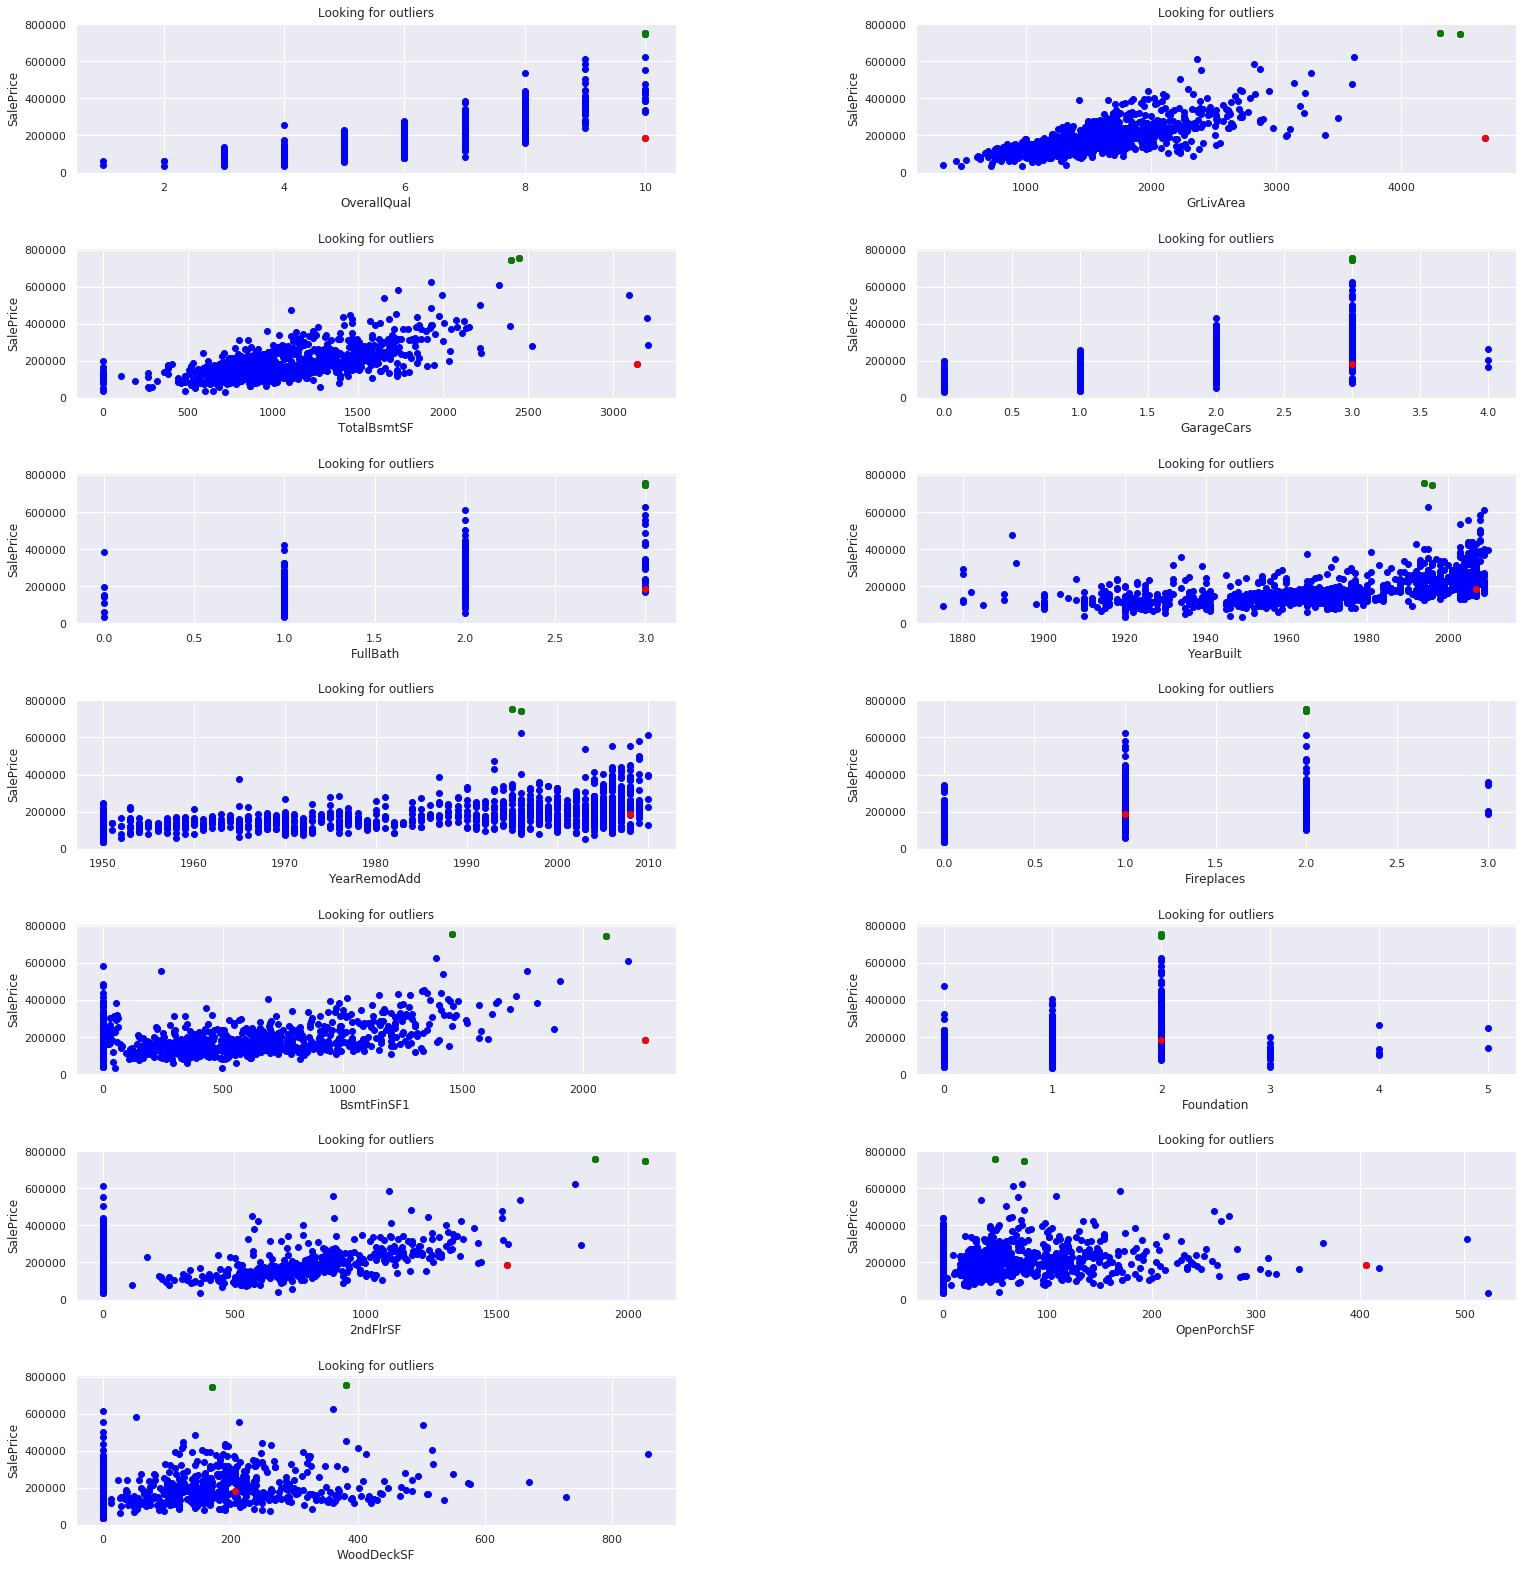

In [28]:
SaleCorr = notCorr_HousePricingDF.corr().SalePrice[corrMatrix.SalePrice >0.3].sort_values(ascending = False)
cols = list(SaleCorr.index)

plt.figure(figsize=(50,60))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,right = 0.5, top = 0.5, wspace = 0.4, hspace =0.5)

for i in range(1,len(cols)):
    plt.subplot(len(cols)//2 +1,2,i)
    plt.scatter(notCorr_HousePricingDF[cols[i]], notCorr_HousePricingDF['SalePrice'], c = "blue", marker = "o")
    plt.scatter(notCorr_HousePricingDF[notCorr_HousePricingDF['GrLivArea'] > 4000][cols[i]], notCorr_HousePricingDF[notCorr_HousePricingDF['GrLivArea'] > 4000]['SalePrice'], c = "red", marker = "o")
    plt.scatter(notCorr_HousePricingDF[notCorr_HousePricingDF['SalePrice'] > 700000][cols[i]], notCorr_HousePricingDF[notCorr_HousePricingDF['SalePrice'] > 700000]['SalePrice'], c = "green", marker = "o")
    plt.title("Looking for outliers")
    plt.xlabel(cols[i])
    plt.ylabel("SalePrice")
plt.show()

It is not easy to find outliers here, since the relations are approximatly linears. But There is one in GrLivErea.

In [29]:
notCorr_HousePricingDF[notCorr_HousePricingDF['GrLivArea'] > 4000]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,3,40094,1,0,0,0,4,0,...,0,0,0,0,0,10,2007,6,5,184750
691,692,60,3,21535,1,0,3,0,0,0,...,0,0,0,0,0,1,2007,8,4,755000
1182,1183,60,3,15623,1,0,3,0,0,0,...,0,0,0,555,0,7,2007,8,0,745000


In [30]:
ReducedHousePricing = notCorr_HousePricingDF.drop(523)

Regarding to the graphs, we can notice that  many values of the TotalBsmfSF are equal to 0. To not affect our model with this data

number of outliers :  60


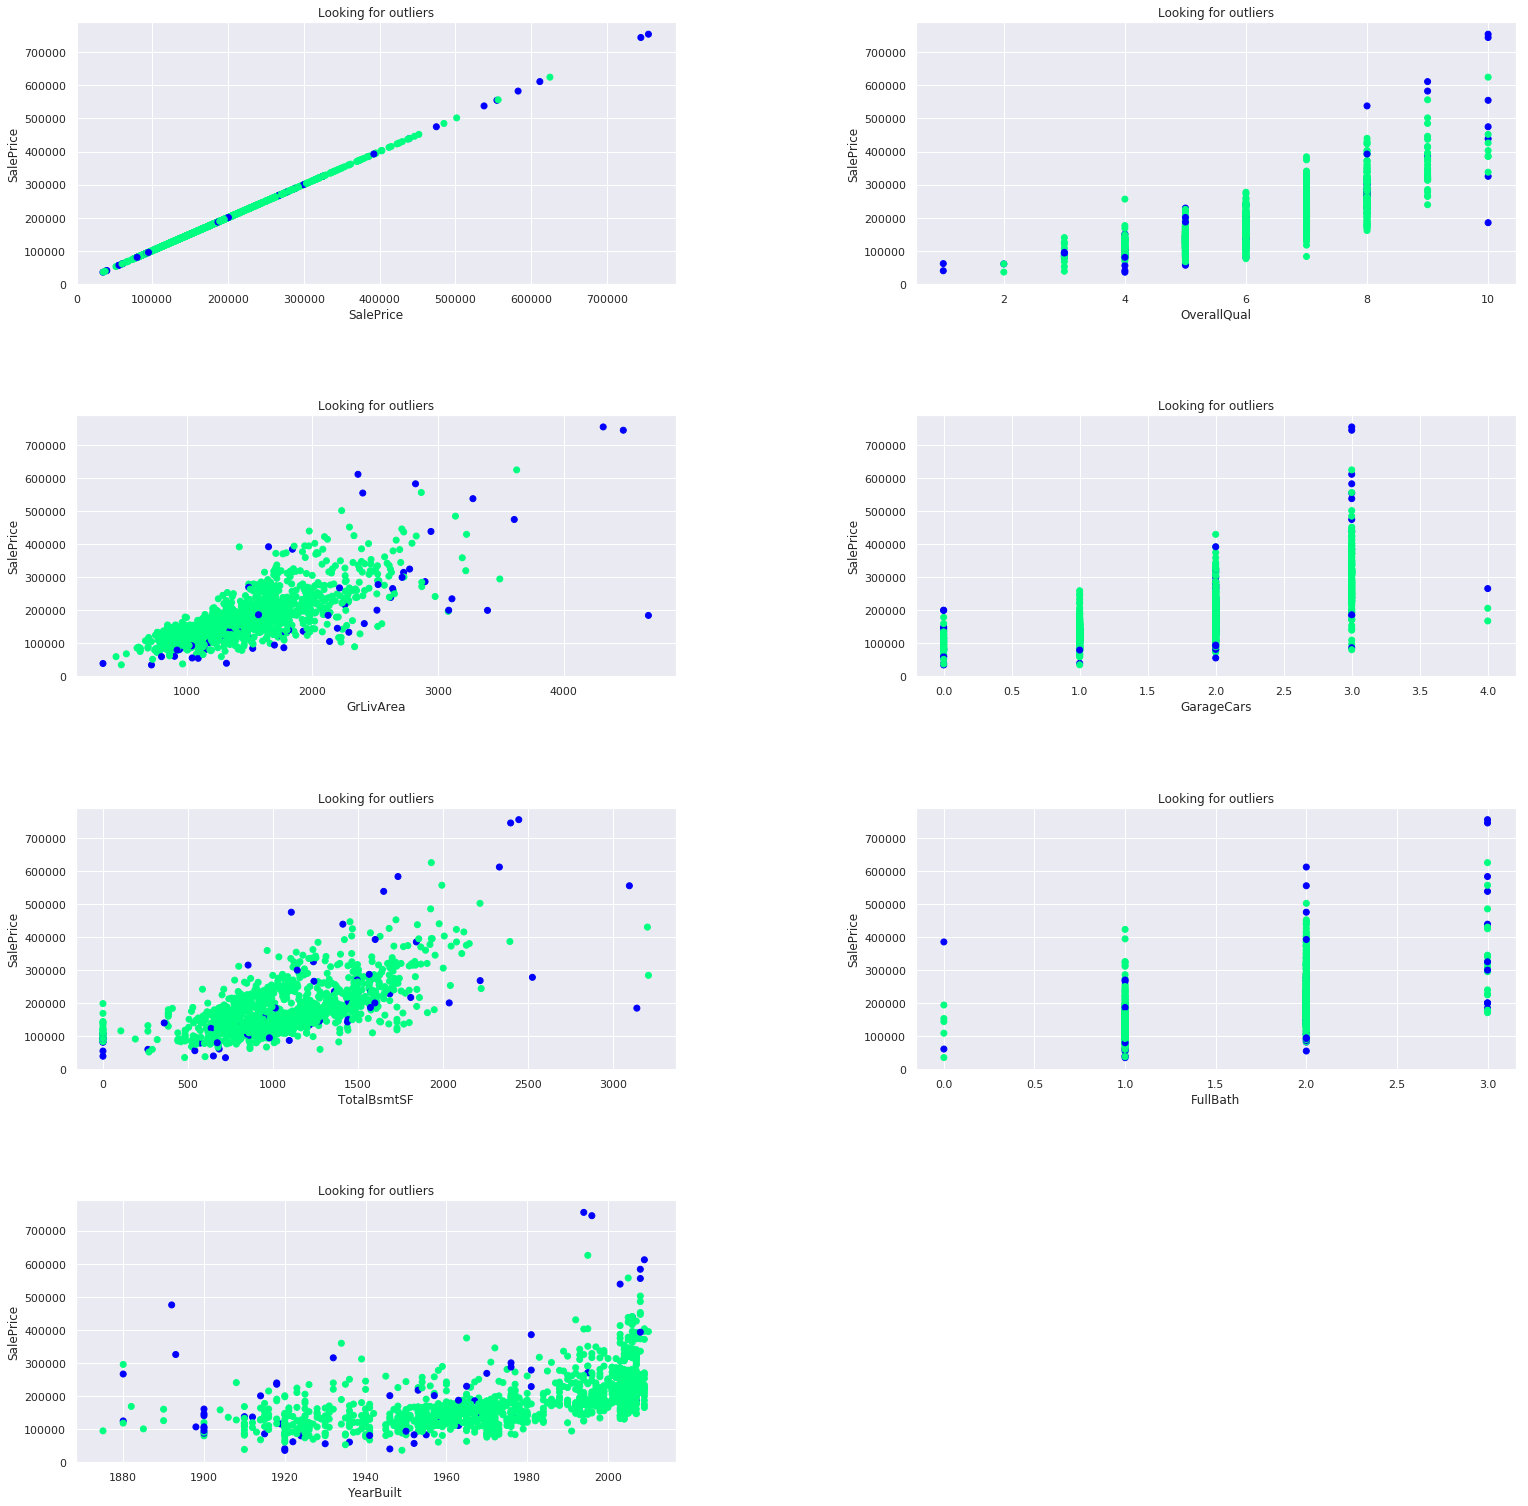

In [31]:
noOutlier_df = notCorr_HousePricingDF.copy()

cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', \
        'TotalBsmtSF', 'FullBath', 'YearBuilt'] #list(cleaned_housePricingDF.select_dtypes(exclude=['object']).columns)[:10]

clf = IsolationForest(contamination=0.05)
clf.fit(noOutlier_df)
pred_outlier = clf.predict(noOutlier_df)


print("number of outliers : ",len(pred_outlier[pred_outlier==-1]))

plt.figure(figsize=(50,50))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,right = 0.5, top = 0.5, wspace = 0.4, hspace =0.5)
cmap = plt.cm.get_cmap("winter")

for i in range(0,len(cols)):
    plt.subplot(len(cols)//2 +1,2,i+1)
    plt.scatter(notCorr_HousePricingDF[cols[i]], notCorr_HousePricingDF['SalePrice'], c = pred_outlier*2, cmap=cmap,marker = "o")
    #plt.scatter()
    plt.title("Looking for outliers")
    plt.xlabel(cols[i])
    plt.ylabel("SalePrice")
plt.show()


It seems like the outliers are mostly the high price houses, which is not surprising since there are only few house with high prices. If we delete those values, the model will be better on medium price house, which is better because this the case for most of the houses.

In [32]:
noOutlier_df["Outlier"] = pred_outlier
noOutlier_df = noOutlier_df.query('Outlier==1')
noOutlier_df = noOutlier_df.drop('Outlier', axis=1)

# 2. Model Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

As it is written, we are using rmsle to evaluate our model. In the end, we used rmse between of lof errors. Moreover, we will use cross validation to make sure our scores are stable.

In [33]:

def get_val_set(df):
    X = df.drop(['SalePrice'], 1)
    y = df['SalePrice']
    return train_test_split(X, y, test_size=0.1)

#Validation function
n_folds = 10

def rmsle_cv(df, model,X_train,y_train):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmsle= np.sqrt(abs(cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf)))
    return(rmsle)    


In [34]:
#keep part of data for validation

X_cl,x_val_cl,y_cl,y_val_cl = get_val_set(cleaned_housePricingDF)
X_corr,x_val_corr,y_corr,y_val_cor = get_val_set(notCorr_HousePricingDF)
X_NA,x_val_NA,y_NA,y_val_NA = get_val_set(withNA_housePricingDF)
X_red,x_val_red,y_red,y_val_red = get_val_set(noOutlier_df)
X_0,x_val_0,y_0,y_val_0 = get_val_set(with0_housePricingDF)  
X_imp,x_val_imp,y_imp,y_val_imp = get_val_set(imputed_housePricingDF)

<h2> Linear regression <h2/>

In [35]:
#Define model
regr = LinearRegression()
results=[]
label = [] 
#filled with NA
t=time()
res = rmsle_cv(withNA_housePricingDF, regr,X_NA,y_NA)
delta = time() - t
results.append(res.mean())
print('For withNA_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#filled with 0
t=time()
res = rmsle_cv(with0_housePricingDF, regr,X_red,y_red)
delta = time() - t
results.append(res.mean())
print('For with0_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#dropping empty columns
t=time()
res = rmsle_cv(cleaned_housePricingDF, regr,X_cl,y_cl)
delta = time() - t
results.append(res.mean())
print('For cleaned_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#without high correlated columns
t=time()
res = rmsle_cv(notCorr_HousePricingDF, regr,X_corr,y_corr)
delta = time() - t
results.append(res.mean())
print('For notCorr_HousePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#outliers removed
t=time()
res = rmsle_cv(noOutlier_df, regr,X_red,y_red)
delta = time() - t
results.append(res.mean())
print('For noOutlier_df, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#filled with means
t=time()
res = rmsle_cv(imputed_housePricingDF, regr,X_red,y_red)
delta = time() - t
results.append(res.mean())
print('For imputed_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

For withNA_housePricingDF, the rmsle is: 33113.8172766 In 0.013669347763061524 sec per iteration in average.
For with0_housePricingDF, the rmsle is: 24716.4303091 In 0.005238080024719238 sec per iteration in average.
For cleaned_housePricingDF, the rmsle is: 32263.3571432 In 0.004463362693786621 sec per iteration in average.
For notCorr_HousePricingDF, the rmsle is: 29984.8549622 In 0.00437161922454834 sec per iteration in average.
For noOutlier_df, the rmsle is: 24716.4303091 In 0.004380083084106446 sec per iteration in average.
For imputed_housePricingDF, the rmsle is: 24716.4303091 In 0.006111502647399902 sec per iteration in average.


As we can see, the linear regressor doesn't give very good results.

<function matplotlib.pyplot.show(*args, **kw)>

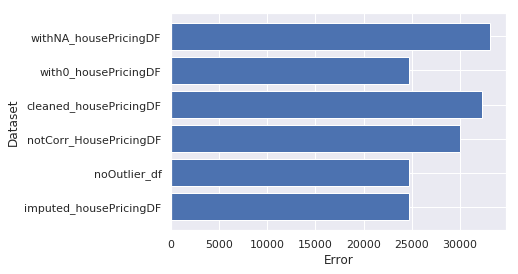

In [36]:
x = range(len(results))
DF =[0,'withNA_housePricingDF', 'with0_housePricingDF', 'cleaned_housePricingDF', 'notCorr_HousePricingDF', 'noOutlier_df', 'imputed_housePricingDF']

fig, ax = plt.subplots()
ax.barh(x, results, align='center')
ax.set_yticklabels(DF)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Error')
ax.set_ylabel('Dataset')
plt.show

The error is minimized with the imputed dataframe and the dataframe in which we removed all the outliers.

<h3> Lasso </h3>



This model is quite appropriate for linear regression problem.

In [37]:
from sklearn.linear_model import Lasso


lasso = Lasso()

results=[]
label = [] 

#filled with NA
t=time()
res = rmsle_cv(withNA_housePricingDF, lasso,X_NA,y_NA)
delta = time() - t
results.append(res.mean())
print('For withNA_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#filled with 0
t=time()
res = rmsle_cv(with0_housePricingDF, lasso,X_red,y_red)
delta = time() - t
results.append(res.mean())
print('For with0_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#dropping empty columns
t=time()
res = rmsle_cv(cleaned_housePricingDF, lasso,X_cl,y_cl)
delta = time() - t
results.append(res.mean())
print('For cleaned_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#without high correlated columns
t=time()
res = rmsle_cv(notCorr_HousePricingDF, lasso,X_corr,y_corr)
delta = time() - t
results.append(res.mean())
print('For notCorr_HousePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#outliers removed
t=time()
res = rmsle_cv(noOutlier_df, lasso,X_red,y_red)
delta = time() - t
results.append(res.mean())
print('For noOutlier_df, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#filled with means
t=time()
res = rmsle_cv(imputed_housePricingDF, lasso,X_red,y_red)
delta = time() - t
results.append(res.mean())
print('For imputed_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

For withNA_housePricingDF, the rmsle is: 33087.4619055 In 0.014951539039611817 sec per iteration in average.
For with0_housePricingDF, the rmsle is: 24710.9908828 In 0.00709228515625 sec per iteration in average.
For cleaned_housePricingDF, the rmsle is: 32258.7434673 In 0.005881762504577637 sec per iteration in average.
For notCorr_HousePricingDF, the rmsle is: 29983.0057402 In 0.010527229309082032 sec per iteration in average.
For noOutlier_df, the rmsle is: 24710.9908828 In 0.013352560997009277 sec per iteration in average.
For imputed_housePricingDF, the rmsle is: 24710.9908828 In 0.014728426933288574 sec per iteration in average.


We have now different datasets more or less cleaned:   

X_cl,x_val_cl,y_cl,y_val_cl = get_val_set(cleaned_housePricingDF)   
X_corr,x_val_corr,y_corr,y_val_cor = get_val_set(notCorr_HousePricingDF)   
X_NA,x_val_NA,y_NA,y_val_NA = get_val_set(withNA_housePricingDF)   
X_red,x_val_red,y_red,y_val_red = get_val_set(ReducedHousePricing)   
X_0,x_val_0,y_0,y_val_0 = get_val_set(with0_housePricingDF)    


<function matplotlib.pyplot.show(*args, **kw)>

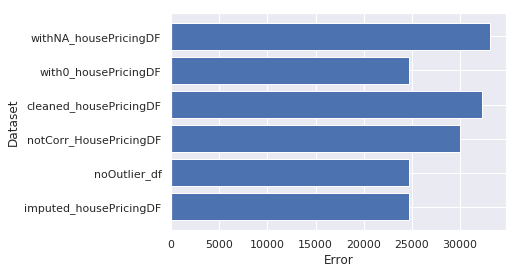

In [38]:
x = range(len(results))
DF =[0,'withNA_housePricingDF', 'with0_housePricingDF', 'cleaned_housePricingDF', 'notCorr_HousePricingDF', 'noOutlier_df', 'imputed_housePricingDF']

fig, ax = plt.subplots()
ax.barh(x, results, align='center')
ax.set_yticklabels(DF)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Error')
ax.set_ylabel('Dataset')
plt.show

<h3> Gradient Boosting </h3>



In [39]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#filled with NA
t=time()
res = rmsle_cv(withNA_housePricingDF, GBoost,X_NA,y_NA)
delta = time() - t
print('For withNA_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#filled with 0
t=time()
res = rmsle_cv(with0_housePricingDF, GBoost,X_0,y_0)
delta = time() - t
print('For with0_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#dropping empty columns
t=time()
res = rmsle_cv(cleaned_housePricingDF, GBoost,X_cl,y_cl)
delta = time() - t
print('For cleaned_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#without high correlated columns
t=time()
res = rmsle_cv(notCorr_HousePricingDF, GBoost,X_corr,y_corr)
delta = time() - t
print('For notCorr_HousePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#outliers removed
t=time()
res = rmsle_cv(noOutlier_df, GBoost,X_red,y_red)
delta = time() - t
print('For noOutlier_df, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

#filled with means
t=time()
res = rmsle_cv(imputed_housePricingDF, GBoost,X_imp,y_imp)
delta = time() - t
print('For imputed_housePricingDF, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')

For withNA_housePricingDF, the rmsle is: 25302.9246327 In 6.67709436416626 sec per iteration in average.
For with0_housePricingDF, the rmsle is: 27215.6851467 In 5.98448121547699 sec per iteration in average.
For cleaned_housePricingDF, the rmsle is: 26018.9702809 In 5.664930129051209 sec per iteration in average.
For notCorr_HousePricingDF, the rmsle is: 24619.5307867 In 5.543506669998169 sec per iteration in average.
For noOutlier_df, the rmsle is: 20052.4645455 In 5.599286794662476 sec per iteration in average.
For imputed_housePricingDF, the rmsle is: 27189.9512101 In 5.700524640083313 sec per iteration in average.


Before we had the error:

For notCorr_HousePricingDF, the rmsle is: 0.12437860743033528 In 5.338083124160766 sec per iteration in average.  
For cleaned_housePricingDF, the rmsle is: 0.13114323779116827 In 5.3367821216583256 sec per iteration in average.  
For withNA_housePricingDF, the rmsle is: 0.12891529924526518 In 5.559273529052734 sec per iteration in average.  

The best result on those primary model are the gradient boosting with the dataset where we removed the outliers. We are now going to optimize our model hyper-parameters. We chose to do it only on this model by lack of time and we would have tunned all the models otherwise.

In [40]:
import scipy.stats 
from sklearn.model_selection import ParameterSampler

# Hyperparameters are now definded by probability densities
hyperparameters = {
    'n_estimators': scipy.stats.randint(2000, 4000), 
    'learning_rate' : scipy.stats.uniform(0.001, 1.)}

parameter_grid = list(ParameterSampler(hyperparameters,10))

resultsDF2 = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'rmse','time'])

for parameter_combination in parameter_grid:  
    GBoost = GradientBoostingRegressor(n_estimators=parameter_combination['n_estimators'], learning_rate=parameter_combination['learning_rate'],
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)

    t=time()
    res = rmsle_cv(noOutlier_df, GBoost,X_red,y_red)
    delta = time() - t
    parameter_combination['rmse'] = res.mean()
    parameter_combination['time'] = delta/n_folds
    resultsDF2 = resultsDF2.append(parameter_combination, ignore_index=True)
    print('For noOutlier_df, the rmsle is: ' +str(res.mean()) + ' In ' + str(delta/n_folds)+' sec per iteration in average.')
    
resultsDF2.sort_values(by = 'rmse', ascending = False)

For noOutlier_df, the rmsle is: 23453.3077403 In 4.991714835166931 sec per iteration in average.
For noOutlier_df, the rmsle is: 21465.3920656 In 5.433174204826355 sec per iteration in average.
For noOutlier_df, the rmsle is: 21030.0638685 In 7.589917993545532 sec per iteration in average.
For noOutlier_df, the rmsle is: 22972.140908 In 7.453226113319397 sec per iteration in average.
For noOutlier_df, the rmsle is: 33648.2876651 In 5.602076268196106 sec per iteration in average.
For noOutlier_df, the rmsle is: 24394.4731909 In 6.629144597053528 sec per iteration in average.
For noOutlier_df, the rmsle is: 24778.9861971 In 6.312721371650696 sec per iteration in average.
For noOutlier_df, the rmsle is: 20814.773869 In 3.8956137895584106 sec per iteration in average.
For noOutlier_df, the rmsle is: 24155.7191077 In 5.532589435577393 sec per iteration in average.
For noOutlier_df, the rmsle is: 27276.3273434 In 6.877439713478088 sec per iteration in average.


,n_estimators,learning_rate,rmse,time
4,3245.0,0.975229,33648.287665,5.602076
9,3535.0,0.658508,27276.327343,6.877440
6,3282.0,0.437853,24778.986197,6.312721
5,3409.0,0.385650,24394.473191,6.629145
8,2875.0,0.376801,24155.719108,5.532589
0,2564.0,0.350498,23453.307740,4.991715
3,3764.0,0.319508,22972.140908,7.453226
1,2792.0,0.183373,21465.392066,5.433174
2,3947.0,0.153856,21030.063868,7.589918
7,2066.0,0.132652,20814.773869,3.895614


Let's compare the best models on there validation results.

In [41]:
def score(true,pred):
    return np.sqrt(mean_squared_error(true,pred))

In [42]:
GBoost1 = GradientBoostingRegressor(n_estimators=3452, learning_rate=0.016336,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)
GBoost2 = GradientBoostingRegressor(n_estimators=2308, learning_rate=0.128971,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)
GBoost3 = GradientBoostingRegressor(n_estimators=2611, learning_rate=0.125108,
                                       max_depth=4, max_features='sqrt',
                                       min_samples_leaf=15, min_samples_split=10, 
                                       loss='huber', random_state =5)

GBoost1.fit(X_red,y_red)
GBoost2.fit(X_red,y_red)
GBoost3.fit(X_red,y_red)

#Let's see on the validation data
y_predict1=GBoost1.predict(x_val_red)
y_predict2=GBoost2.predict(x_val_red)
y_predict3=GBoost3.predict(x_val_red)
    
sc1 = score(y_val_red, y_predict1)
sc2 = score(y_val_red, y_predict2)
sc3 = score(y_val_red, y_predict3)
print([sc1,sc2,sc3])

[21339.124766861347, 23350.131099507355, 22675.393298622319]


The results are not as good ad the previous ones, but it is not surprising.



Let's plot the results

In [43]:
GBoost1.fit(X_red, y_red)
y_predict_gboost=GBoost1.predict(x_val_red)
y_test_list_gboost=y_val_red.tolist()

gBoost = pd.DataFrame({'value_expected' : y_test_list_gboost, 'GBoost_predictedValue': y_predict_gboost})

Accuracy: 0.92 (+/- 0.03)


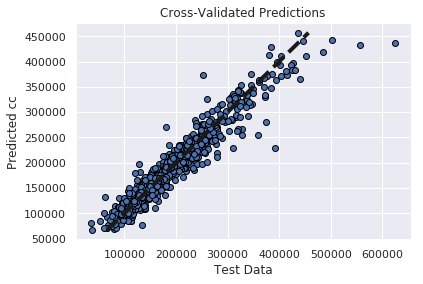

In [44]:
#CROSS VALIDATION 

from sklearn import datasets
from sklearn.model_selection import cross_val_score

scores = cross_val_score(GBoost1, X_red, y_red, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(GBoost1, X_red, y_red, cv=5)
#print(y_pred[0:10])
y_cv_test_list_gboost=y_pred.tolist()

gBoost["GBoost_crossValidationValue"]=np.array([int(i) for i in y_predict_gboost])
gBoost[0:10]

#https://scikit-learn.org/stable/modules/cross_validation.html


from sklearn import linear_model


# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

fig, ax = plt.subplots()
ax.scatter(y_red, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=4)
ax.set_xlabel('Test Data')
ax.set_ylabel('Predicted cc')
plt.title("Cross-Validated Predictions")
plt.show()

We can see that our model is quite accurate. Indeed the cross compilation shows that our model is correctly trained even if there are still some values "out of range" which are not well predicted, especially for houses whose price is greater than 400 000 dollars. But this is logical as 98 per cent of the houses from the dataset have a price under 400 000 dollars (cf question1), which let only 2% of data to train a good model for this minority of houses.

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

In [48]:
#Getting our test data
test = pd.read_csv('challenge_data/test.csv')

test['Electrical'] = test['Electrical'].fillna(0) #there is a missing value in a columns there were no missing value before

In [51]:
#find the columns with missing values
total = test.isnull().sum().sort_values(ascending=False)
to_drop_test = list(total.where(total > 0).dropna().index)

#drop the missing values
cleaned_test = test.drop(to_drop_test, 1)

#Put labels on string values
cleaned_test = label(cleaned_test)

#Remove redundancy
notCorr_test = cleaned_test.drop(['Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea'],1) #remove them from the dataFrame

In [52]:
#Train our favorite model
X = noOutlier_df.drop(['SalePrice'], 1)
y = noOutlier_df['SalePrice']
GBoost1.fit(X, y)

In [53]:
#Make predictions
predictions = GBoost1.predict(notCorr_test)

my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)